In [63]:
import os
import json
from time import sleep

from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
import pandas as pd
from graphdatascience import GraphDataScience
from neo4j import GraphDatabase
import torch
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv
from torch_geometric.transforms import RandomNodeSplit
from torch_geometric.data import HeteroData
import random
import numpy as np
from torch.nn.modules.loss import TripletMarginLoss
import matplotlib.pyplot as plt

from src.shared.database_wrapper import DatabaseWrapper
from src.datasets.who_is_who import WhoIsWhoDataset
from src.model.GAT.gat_encoder import GATv2Encoder
from src.model.GAT.gat_decoder import GATv2Decoder
from src.shared.graph_schema import NodeType, EdgeType, node_one_hot, edge_one_hot, edge_pyg_key_vals
from src.model.loss.triplet_loss import TripletLoss
from src.shared import config

import networkx as nx
import plotly.graph_objects as go

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

In [64]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv, HeteroConv
from torch_geometric.nn import Linear


class TestGATv2Encoder(torch.nn.Module):
    def __init__(
            self,
            in_channels,
            hidden_channels,
            out_channels,
            edge_feature_dim,
            edge_types,
            node_types,
            heads=5,
            concat=True,
            negative_slope=0.2,
            dropout=0.0,
            add_self_loops=True
    ):
        super(TestGATv2Encoder, self).__init__()

        self.conv_1 = HeteroConv({
            edge_type: GATv2Conv(
                in_channels=in_channels,
                out_channels=hidden_channels,
                heads=heads,
                concat=concat,
                negative_slope=negative_slope,
                dropout=dropout,
                add_self_loops=add_self_loops,
                edge_dim=edge_feature_dim
            )
            for edge_type in edge_types
        }, aggr='mean')

        self.conv_2 = HeteroConv({
            edge_type: GATv2Conv(
                in_channels=heads * hidden_channels if concat else hidden_channels,
                out_channels=hidden_channels,
                heads=heads,
                concat=concat,
                negative_slope=negative_slope,
                dropout=dropout,
                add_self_loops=add_self_loops,
                edge_dim=edge_feature_dim
            )
            for edge_type in edge_types
        }, aggr='mean')

        self.lin_out = torch.nn.ModuleDict()
        for node_type in node_types:
            self.lin_out[node_type] = torch.nn.Sequential(
                Linear(heads * hidden_channels, hidden_channels),
                torch.nn.Dropout(dropout),
                Linear(hidden_channels, out_channels)
            )

    def forward(self, x_dict, edge_index_dict, edge_feature_dict):
        """
        :param x_dict: dict of torch.Tensor
            Node feature vectors for each node type.
        :param edge_index_dict: dict of torch.Tensor
            Edge indices for each edge type.
        :param edge_feature_dict: dict of torch.Tensor
            Edge attribute vectors for each edge type.
        """
        
        x_dict = self.conv_1(x_dict, edge_index_dict, edge_feature_dict)
        for node_type in x_dict.keys():
            x_dict[node_type] = F.dropout(F.relu(x_dict[node_type]), p=0.5, training=self.training)

        x_dict = self.conv_2(x_dict, edge_index_dict, edge_feature_dict)
        for node_type in x_dict.keys():
            x_dict[node_type] = F.dropout(F.relu(x_dict[node_type]), p=0.5, training=self.training)

        out_dict = {}
        for node_type in x_dict.keys():
            out_dict[node_type] = self.lin_out[node_type](x_dict[node_type])

        return out_dict

In [65]:
node_feature_dim = 32
edge_feature_dim = EdgeType.SIM_TITLE.one_hot().shape[0]
gat_embedding_dim = 32

included_nodes = [
    NodeType.PUBLICATION, 
    NodeType.VENUE, 
    NodeType.ORGANIZATION,
    NodeType.AUTHOR,
    NodeType.CO_AUTHOR
]
included_edges = [
    EdgeType.PUB_VENUE,
    EdgeType.VENUE_PUB,
    EdgeType.PUB_ORG,
    EdgeType.ORG_PUB, 
    EdgeType.PUB_AUTHOR,
    EdgeType.AUTHOR_PUB,
    EdgeType.AUTHOR_ORG,
    EdgeType.ORG_AUTHOR,
    EdgeType.PUB_ORG,
    EdgeType.ORG_PUB,
]

device = torch.device(
    'cuda' if torch.cuda.is_available()
    else 'cpu'
)
print(device)

encoder = TestGATv2Encoder(
    in_channels=node_feature_dim,
    hidden_channels=32,
    out_channels=gat_embedding_dim,
    edge_feature_dim=edge_feature_dim,
    edge_types=[edge_pyg_key_vals[edge_type] for edge_type in included_edges],
    node_types=[node_type.value for node_type in included_nodes],
    add_self_loops=False
)
encoder.to(device)

cuda


TestGATv2Encoder(
  (conv_1): HeteroConv(num_relations=8)
  (conv_2): HeteroConv(num_relations=8)
  (lin_out): ModuleDict(
    (Publication): Sequential(
      (0): Linear(160, 32, bias=True)
      (1): Dropout(p=0.0, inplace=False)
      (2): Linear(32, 32, bias=True)
    )
    (Venue): Sequential(
      (0): Linear(160, 32, bias=True)
      (1): Dropout(p=0.0, inplace=False)
      (2): Linear(32, 32, bias=True)
    )
    (Organization): Sequential(
      (0): Linear(160, 32, bias=True)
      (1): Dropout(p=0.0, inplace=False)
      (2): Linear(32, 32, bias=True)
    )
    (Author): Sequential(
      (0): Linear(160, 32, bias=True)
      (1): Dropout(p=0.0, inplace=False)
      (2): Linear(32, 32, bias=True)
    )
    (CoAuthor): Sequential(
      (0): Linear(160, 32, bias=True)
      (1): Dropout(p=0.0, inplace=False)
      (2): Linear(32, 32, bias=True)
    )
  )
)

In [66]:
class TripletDataset:
    def __init__(self, dataset_path, train=0.7, eval=0.2, max_samples=None):
        self.dataset_path = dataset_path
        self.batch_files = os.listdir(dataset_path)
        if max_samples:
            self.batch_files = random.sample(self.batch_files, max_samples)
            
        self.num_train_files = int(len(self.batch_files) * train)
        self.num_eval_files = int(len(self.batch_files) * eval)
        self.num_test_files = len(self.batch_files) - self.num_train_files - self.num_eval_files
        
        self.train = self.batch_files[:self.num_train_files]
        self.eval = self.batch_files[self.num_train_files:self.num_train_files+self.num_eval_files]
        self.test = self.batch_files[self.num_train_files+self.num_eval_files:]
        
        # Iterate over all files and count the number of normal and outlier samples
        self.num_train_samples = self.count_samples(self.train, dataset_path)
        self.num_eval_samples = self.count_samples(self.eval, dataset_path)
        self.num_test_samples = self.count_samples(self.test, dataset_path)
        
        print(
            f"Number of training samples: {self.num_train_samples},\n"
            f"Number of eval samples: {self.num_eval_samples},\n"
            f"Number of test samples: {self.num_test_samples}"
        )
        
    def iter_generated_triplets(self, eval=False, test=False):
        if eval:
            batch_files = self.eval
        elif test:
            batch_files = self.test
        else:
            batch_files = self.train
            
        for batch_file in batch_files:
            file_path = os.path.join(self.dataset_path, batch_file)
            batch = torch.load(file_path)[0]
                
            # print(f"Normal data: {len(batch['normal_data']['graphs'])}, Outliers: {len(batch['outliers']['graphs'])}")
            
            normal_data = batch['normal_data']['graphs']
            outliers = batch['outliers']['graphs']
            
            if len(normal_data) < 4:
                continue
            if len(normal_data) < 2:
                continue
                
            # Sample random triplets
            for i, anchor in enumerate(normal_data):
                pos = random.choice(normal_data[:i] + normal_data[i+1:])
                for neg in outliers:
                    yield anchor, pos, neg
    
    @staticmethod
    def count_samples(batch_files, dataset_path):
        num_triplets = 0
        for batch_file in batch_files:
            file_path = os.path.join(dataset_path, batch_file)
            batch = torch.load(file_path)[0]
            
            num_triplets += len(batch['normal_data']['graphs']) * len(batch['outliers']['graphs'])
           
        return num_triplets

In [67]:
def plot_loss(loss, acc, save_file: str = 'plot.png'):
    plt.close()
    path = "./data/plots/"
    if not os.path.exists(path):
        os.makedirs(path)
    save_file = os.path.join(path, save_file)
    
    plt.figure(figsize=(10, 6))
    plt.plot(loss, marker='o', linestyle='-', color='b')
    plt.plot(acc, marker='o', linestyle='-', color='r')
    
    plt.xlabel(f'Epochs')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    
    plt.grid(True)
    plt.savefig(save_file)
    plt.show()
    
    
def train(encoder, data_loader: TripletDataset, optimizer, triplet_loss):
    encoder.train()
    
    total_loss = 0
    
    # Training loop
    for anchor, pos, neg in data_loader.iter_generated_triplets():            
        anchor = anchor.to(device)
        pos = pos.to(device)
        neg = neg.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        anchor_emb = encoder.forward(anchor.x_dict, anchor.edge_index_dict, anchor.edge_attr_dict)
        pos_emb = encoder.forward(pos.x_dict, pos.edge_index_dict, pos.edge_attr_dict)
        neg_emb = encoder.forward(neg.x_dict, neg.edge_index_dict, neg.edge_attr_dict)
        
        # Retrieve embedding of respective start nodes
        anchor_emb = anchor_emb["Publication"][0]
        pos_emb = pos_emb["Publication"][0]
        neg_emb = neg_emb["Publication"][0]
        #print(anchor_emb.shape, pos_emb.shape, neg_emb.shape)
        
        loss = triplet_loss(anchor_emb, pos_emb, neg_emb)
        
        # Backward pass
        loss.backward()

        # Optimize the parameters
        optimizer.step()

        total_loss += loss.item()
        
    return total_loss / data_loader.num_train_samples

def validate(encoder, data_loader: TripletDataset, triplet_loss):
    encoder.eval()
    
    total_loss = 0
    
    # Validation loop
    with torch.no_grad():
        for anchor, pos, neg in data_loader.iter_generated_triplets(eval=True):            
            anchor = anchor.to(device)
            pos = pos.to(device)
            neg = neg.to(device)
            
            anchor_emb = encoder.forward(anchor.x_dict, anchor.edge_index_dict, anchor.edge_attr_dict)
            pos_emb = encoder.forward(pos.x_dict, pos.edge_index_dict, pos.edge_attr_dict)
            neg_emb = encoder.forward(neg.x_dict, neg.edge_index_dict, neg.edge_attr_dict)
            
            # Retrieve embedding of respective start nodes
            anchor_emb = anchor_emb["Publication"][0]
            pos_emb = pos_emb["Publication"][0]
            neg_emb = neg_emb["Publication"][0]
            
            loss = triplet_loss(anchor_emb, pos_emb, neg_emb)
            total_loss += loss.item()
    
    return total_loss / data_loader.num_eval_samples

def test(model, data_loader: TripletDataset):
    model.eval()
    
    accuracy = []
    with torch.no_grad():
        for anchor, pos, neg in data_loader.iter_generated_triplets(test=True):            
            anchor.to(device)
            pos.to(device)
            neg.to(device)
            
            anchor_emb = encoder.forward(anchor.x_dict, anchor.edge_index_dict, anchor.edge_attr_dict)
            pos_emb = encoder.forward(pos.x_dict, pos.edge_index_dict, pos.edge_attr_dict)
            neg_emb = encoder.forward(neg.x_dict, neg.edge_index_dict, neg.edge_attr_dict)
            
            # Retrieve embedding of respective start nodes
            anchor_emb = anchor_emb["Publication"][0]
            pos_emb = pos_emb["Publication"][0]
            neg_emb = neg_emb["Publication"][0]
            
            pos_dist = F.pairwise_distance(anchor_emb, pos_emb, p=2)
            neg_dist = F.pairwise_distance(anchor_emb, neg_emb, p=2)
            
            score = 1 if pos_dist < neg_dist else 0
            accuracy.append(score)
    
    # Return percentage of correct predictions 
    return sum(accuracy) / len(accuracy)
            

Number of training samples: 56155,
Number of eval samples: 23432,
Number of test samples: 5327
Epoch 1/50
Training Loss: 21.4883
Validation Loss: 1.0000


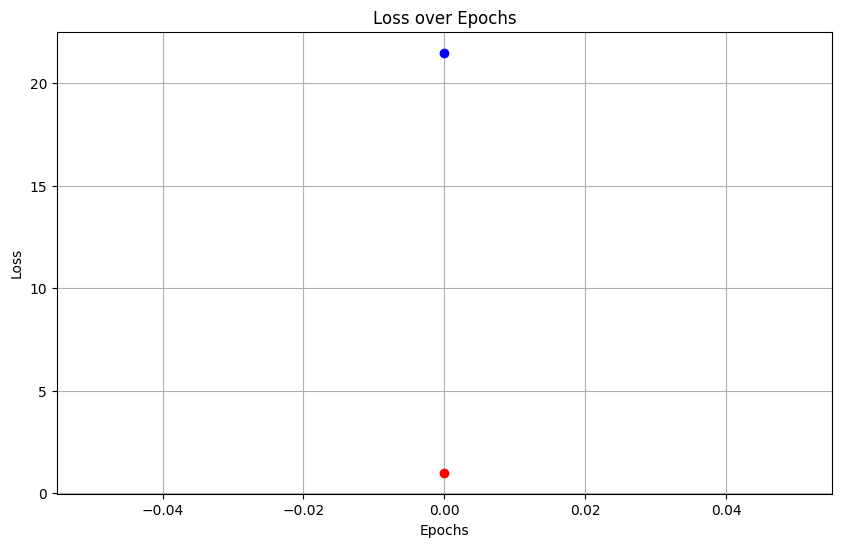

New best model found and saved.
Epoch 2/50
Training Loss: 1.4783
Validation Loss: 1.0000


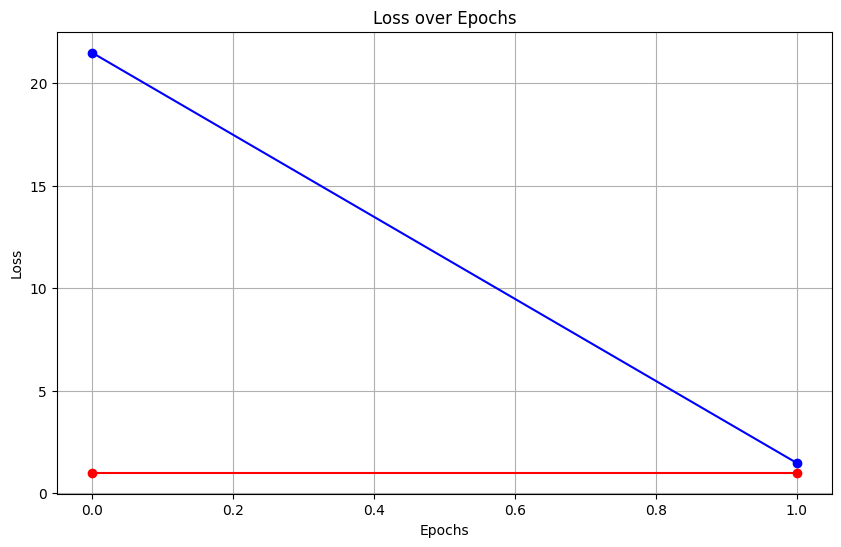

New best model found and saved.
Epoch 3/50
Training Loss: 1.1611
Validation Loss: 1.0000


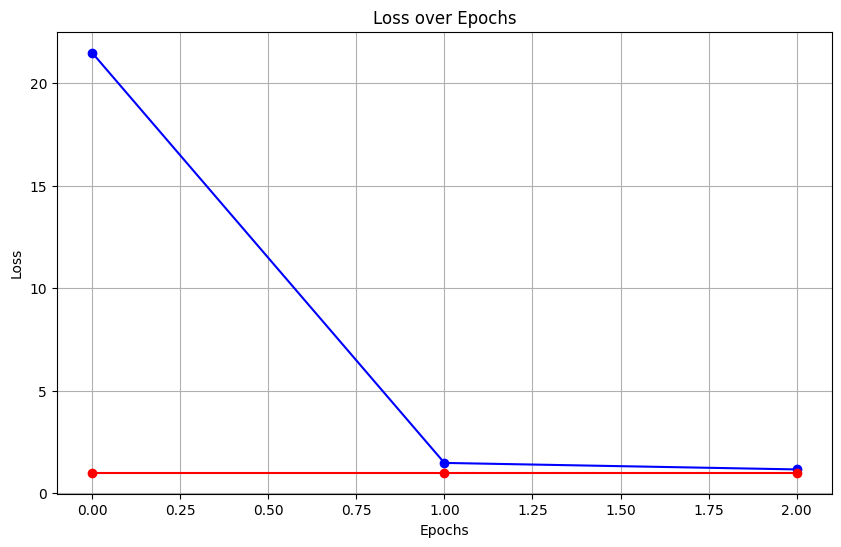

New best model found and saved.
Epoch 4/50
Training Loss: 1.1709
Validation Loss: 1.0000


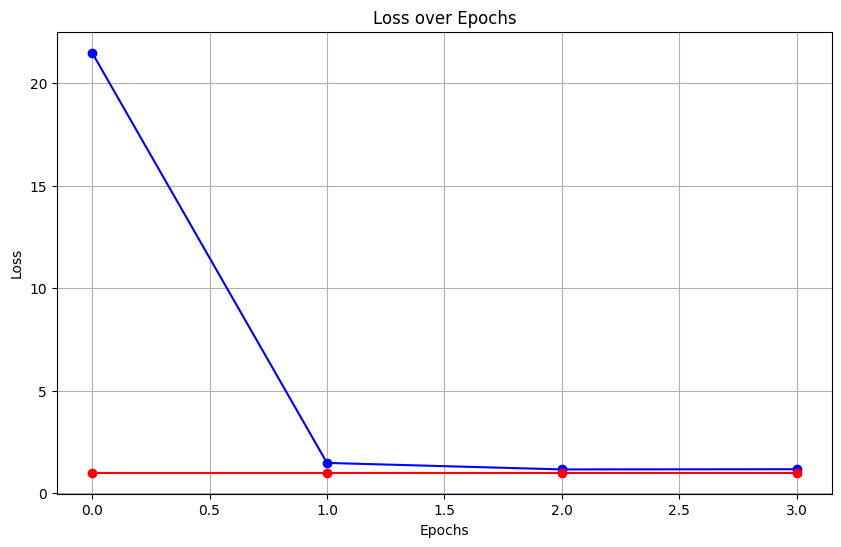

Epoch 5/50
Training Loss: 1.2427
Validation Loss: 1.0000


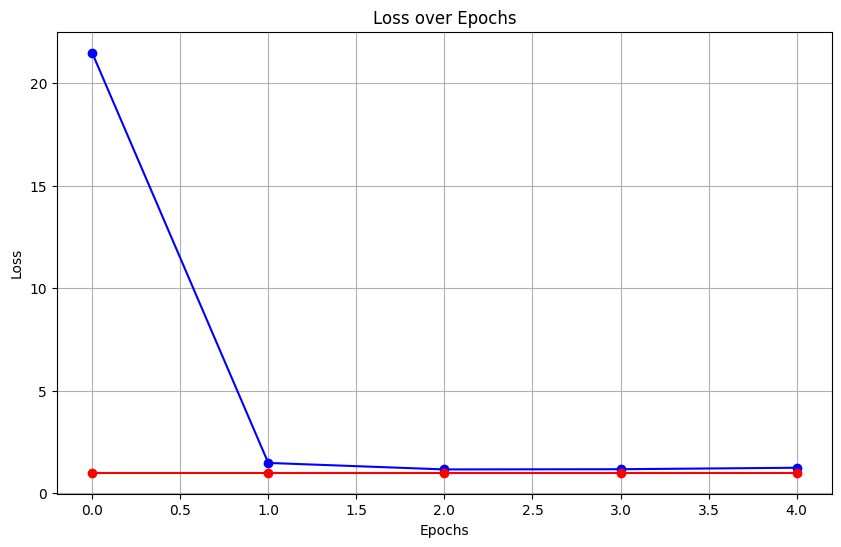

New best model found and saved.
Epoch 6/50
Training Loss: 1.1209
Validation Loss: 1.0000


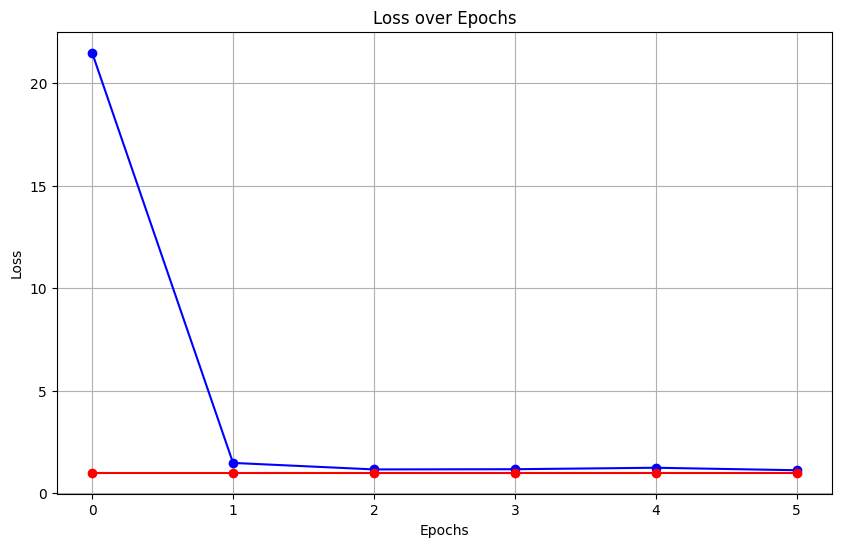

New best model found and saved.
Epoch 7/50
Training Loss: 1.1852
Validation Loss: 1.0000


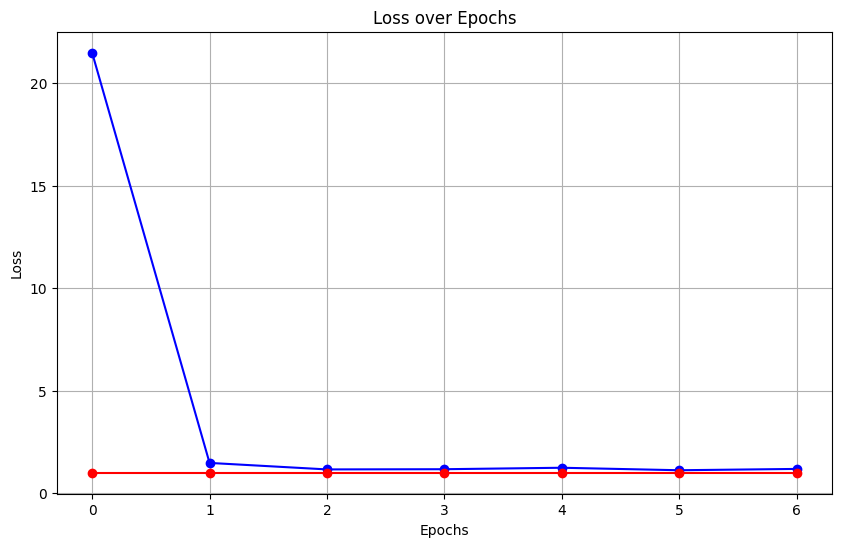

Epoch 8/50
Training Loss: 1.0956
Validation Loss: 1.0000


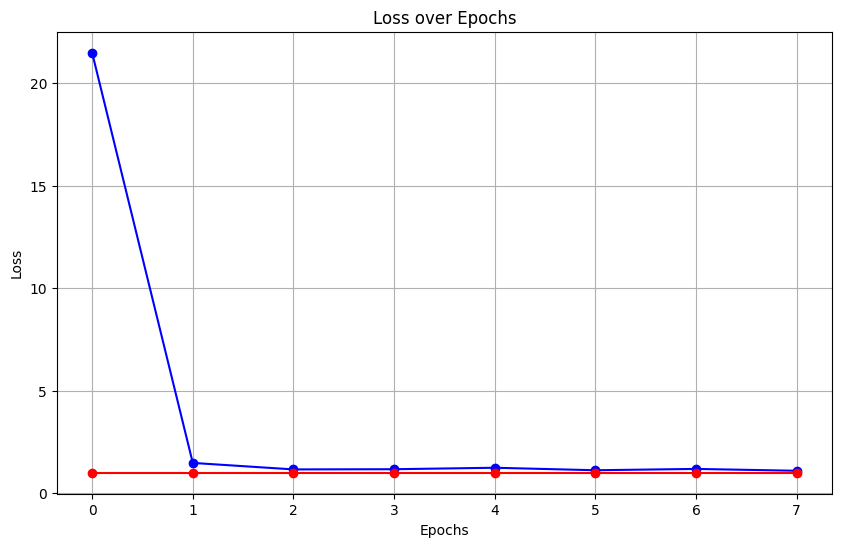

New best model found and saved.
Epoch 9/50
Training Loss: 1.0885
Validation Loss: 1.0000


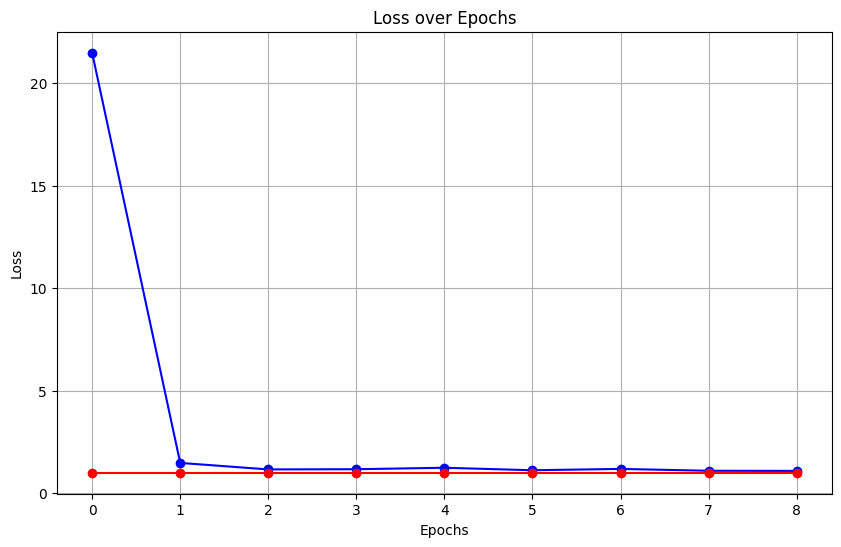

Epoch 10/50


KeyboardInterrupt: 

In [68]:
triplet_loss = TripletMarginLoss(margin=1.0, p=2, eps=1e-7)
optimizer = optim.Adam(list(encoder.parameters()), lr=0.01)
ds = TripletDataset("./data/train_set")

# Number of epochs
num_epochs = 50

# To keep track of the best validation performance
best_val_loss = float('inf')
best_model_state = None
save_path = "./data/models/"
if not os.path.exists(save_path):
    os.makedirs(save_path)
    
train_losses = []
val_losses = []

for epoch in range(1, num_epochs + 1):
    print(f"Epoch {epoch}/{num_epochs}")

    # Training
    train_loss = train(encoder, ds, optimizer, triplet_loss)
    train_losses.append(train_loss)
    print(f"Training Loss: {train_loss:.4f}")
    
    # Validation
    val_loss = validate(encoder, ds, triplet_loss)
    val_losses.append(val_loss)
    print(f"Validation Loss: {val_loss:.4f}")
    
    plot_loss(train_losses, val_losses, save_file=f"gat_loss.png")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = encoder.state_dict()
        torch.save(best_model_state, os.path.join(save_path, "gat_encoder.pt"))
        print("New best model found and saved.")
    
    



In [69]:
# Load best model state
best_model_state = torch.load(os.path.join(save_path, "gat_encoder.pt"))
encoder.load_state_dict(best_model_state)
ds = TripletDataset("./data/train_set")
# Testing
accuracy_score = test(encoder, ds)
print(f"Accuracy: {accuracy_score:.4f}")

Number of training samples: 56155,
Number of eval samples: 23432,
Number of test samples: 5327
Accuracy: 0.3743
